In [1]:
import sys
sys.path.append('../src/')

import torch
import os

#from models.u_net import UNet
from models.unet import UNet
from data.dataset import SegmentationDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary
import torchvision.transforms as transforms
from features.tensor_transforms import Create2D, Rescale, AddChannel, NormalizeSample
from utils.utils import inspect_single_data_pair
from utils.eval_metrics import DiceLoss
import torch.optim

/home/moritz/anaconda3/envs/Registration/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# constants
DATASET_PATH = '../data/raw/EMPIRE10/scans/'
DATA_OUT_s = '/home/moritz/Thesis/ImageRegistration/data/interim/EMPIRE10/scans/'
DATA_OUT_m = '/home/moritz/Thesis/ImageRegistration/data/interim/EMPIRE10/masks/'

In [3]:
filename = list(set([x.split('_')[0]
                     for x in os.listdir(DATASET_PATH)]))
partition = {}
partition['train'], partition['validation'] = train_test_split(
    filename, test_size=0.33, random_state=42)

shape=(256, 256)
transform = transforms.Compose([
    # Data Preprocessing
    Create2D('y'),
    AddChannel(axs=0),
    Rescale(shape)
])


In [4]:
#inspect_single_data_pair('SegmentationDataset', partition['train'], dataset='EMPIRE10', transform=transform)

In [5]:
# Generators
training_set = SegmentationDataset(partition['train'], dataset='EMPIRE10', transform=transform)
print(training_set)
batch_size=1
training_loader = DataLoader(training_set, batch_size=batch_size,
		                                shuffle=True, pin_memory=True)

In [6]:
# inspect model before training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

#model = UNet().to(device)
model = UNet()
#summary(model, (1, 256, 256))

In [7]:
x = next(iter(training_loader))

In [8]:
x[0].shape

torch.Size([1, 1, 256, 256])

In [9]:
#x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32).to(device)
#print()
with torch.no_grad():
    out = model(x[0])
print(out)

tensor([[[[0.4238, 0.0382, 0.2363,  ..., 0.2329, 0.4358, 0.3434],
          [0.1532, 0.0416, 0.0283,  ..., 0.1077, 0.4026, 0.4546],
          [0.2460, 0.4735, 0.0425,  ..., 0.1350, 0.0431, 0.1734],
          ...,
          [0.6784, 0.1140, 0.1390,  ..., 0.0423, 0.0052, 0.0745],
          [0.4484, 0.0502, 0.0663,  ..., 0.0064, 0.0249, 0.5022],
          [0.6465, 0.0598, 0.0619,  ..., 0.0031, 0.0040, 0.0345]]]])


In [10]:
from utils.utils import LearningRateFinder
optimizer = torch.optim.Adam(model.parameters())
criterion = DiceLoss()

In [11]:
lrf = LearningRateFinder(model, criterion, optimizer, device="cuda")
lrf.fit(training_loader, steps=1000)

Progress: 100%|██████████| 50/50 [05:21<00:00,  6.43s/it]


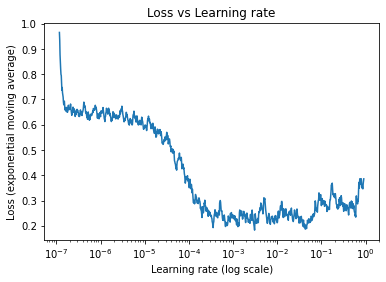

In [12]:
lrf.plot()